In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT

In [6]:
print(f"Torch: {torch.__version__}")
torch.cuda.empty_cache()

Torch: 2.3.1+cu121


In [7]:
# Training settings
batch_size = 32
epochs = 10
lr = 3e-5
gamma = 0.7
seed = 42

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [9]:
device = 'cuda'

In [24]:
root_dir = './train'

train_list = []
for subdir, dirs, files in os.walk(root_dir):
    if os.path.basename(subdir) == 'imgs':
        for file in files:
            train_list.append(os.path.join(subdir, file))

In [25]:
print(len(train_list))
random.shuffle(train_list)

27773
1271


In [26]:
labels = [path.split('/')[-1].split('.')[2] for path in train_list]
print(len(labels))

27773


In [27]:
from sklearn.model_selection import LeaveOneGroupOut
groups = [path.split('/')[-1].split('.')[0] for path in train_list]

In [28]:
train_list_og = train_list

In [30]:
# random_idx = np.random.randint(1, len(train_list), size=9)
# # random_idx = [500, 600, 700, 800, 900, 1000, 2000, 1100, 1200]
# fig, axes = plt.subplots(3, 3, figsize=(16, 12))

# for idx, ax in enumerate(axes.ravel()):
#     img = Image.open(train_list[idx])
#     ax.set_title(labels[idx])
#     ax.imshow(img)

In [31]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [32]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")

Train Data: 22218
Validation Data: 5555
Test Data: 1271


In [17]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [16]:
class ObjectClassification(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[2]
        # label = 'hard'
        label = 1 if label == "hard" else 0

        return img_transformed, label

In [35]:
train_data = ObjectClassification(train_list, transform=train_transforms)
valid_data = ObjectClassification(valid_list, transform=test_transforms)

In [36]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)

In [37]:
print(len(train_data), len(train_loader))

22218 695


In [38]:
print(len(valid_data), len(valid_loader))

5555 174


In [39]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [22]:
from vit_pytorch.vit_for_small_dataset import ViT

model = ViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 2,
    dim = 128,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

In [71]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [25]:
import gc
gc.collect()
torch.cuda.empty_cache()

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/695 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.5652 - acc: 0.6689 - val_loss : 0.4453 - val_acc: 0.7641



  0%|          | 0/695 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.4813 - acc: 0.7508 - val_loss : 0.3627 - val_acc: 0.8682



  0%|          | 0/695 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.4520 - acc: 0.7732 - val_loss : 0.4493 - val_acc: 0.7696



  0%|          | 0/695 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.4352 - acc: 0.7882 - val_loss : 0.3667 - val_acc: 0.8497



  0%|          | 0/695 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.4030 - acc: 0.8088 - val_loss : 0.2799 - val_acc: 0.8914



  0%|          | 0/695 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.3771 - acc: 0.8255 - val_loss : 0.4337 - val_acc: 0.7521



  0%|          | 0/695 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.3565 - acc: 0.8375 - val_loss : 0.2561 - val_acc: 0.8948



  0%|          | 0/695 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.3414 - acc: 0.8447 - val_loss : 0.2512 - val_acc: 0.9066



  0%|          | 0/695 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.3197 - acc: 0.8579 - val_loss : 0.2058 - val_acc: 0.9169



  0%|          | 0/695 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.3038 - acc: 0.8642 - val_loss : 0.2019 - val_acc: 0.9241



In [26]:
torch.save(model.state_dict(), './trained-vit-v2.pt')


In [4]:
from vit_pytorch.vit_for_small_dataset import ViT
# Load the model
def load_model(model_path, device, num_classes):
    model = ViT(
        image_size = 224,
        patch_size = 32,
        num_classes = num_classes,
        dim = 128,
        depth = 6,
        heads = 16,
        mlp_dim = 2048,
        dropout = 0.1,
        emb_dropout = 0.1
    ).to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set the model to evaluation mode
    return model

# Evaluate the model on the test dataset
def evaluate_model(model, test_loader, device, y_pred, y_true):
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_loader)
            epoch_val_loss += val_loss / len(test_loader)

            y_pred.append(val_output.argmax(dim=1))
            y_true.append(label)

    return acc, y_pred, y_true

def main():
    # Paths and parameters
    model_path = './trained-vit-v2.pt'
    num_classes = 2  # Adjust this according to your dataset
    batch_size = 32
    model = load_model(model_path,device, num_classes)

    # Evaluate the model
    accuracy = evaluate_model(model, test_loader, device)
    print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')

In [22]:
if __name__ == '__main__':
    main()


Accuracy of the model on the test dataset: 74.78%


12170
Test Data: 12170


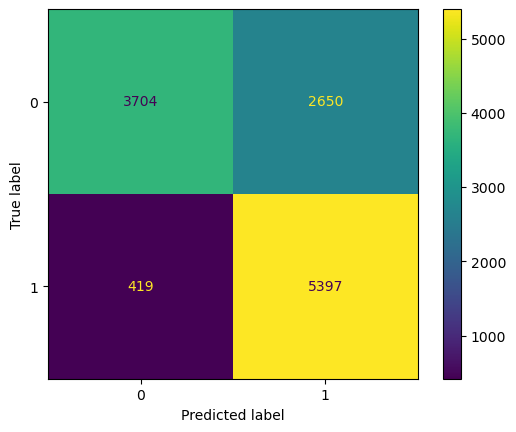

In [211]:
root_dir = './test'

test_list = []
for subdir, dirs, files in os.walk(root_dir):
    if os.path.basename(subdir) == 'imgs':
        for file in files:
            test_list.append(os.path.join(subdir, file))

print(len(test_list))
random.shuffle(test_list)

print(f"Test Data: {len(test_list)}")

test_data = ObjectClassification(test_list, transform=test_transforms)

test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

y_pred = []
y_true = []

model_path = './trained-vit-v2.pt'
num_classes = 2  # Adjust this according to your dataset
batch_size = 32
model = load_model(model_path,device, num_classes)

accuracy, y_pred, y_true= evaluate_model(model, test_loader, device, y_pred, y_true)

y_true_list = [tensor.cpu().numpy().flatten() for tensor in y_true]
yt = np.concatenate(y_true_list)
y_pred_list = [tensor.cpu().numpy().flatten() for tensor in y_pred]
yp = np.concatenate(y_pred_list)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(yt, yp)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [10]:
model_path = './trained-vit-v2.pt'
num_classes = 2  # Adjust this according to your dataset
batch_size = 32
model = load_model(model_path,device, num_classes)

# print(accuracy)

In [11]:
proba = model.predict(test_data, batch_size=32)

AttributeError: 'ViT' object has no attribute 'predict'

In [12]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ViTFeatureExtractor.from_pretrained('./trained-vit-v2.pt')
model = ViTForImageClassification.from_pretrained('./trained-vit-v2.pt')



UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 64: invalid start byte

In [ ]:
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

In [14]:
model = ViT(
        image_size = 224,
        patch_size = 32,
        num_classes = num_classes,
        dim = 128,
        depth = 6,
        heads = 16,
        mlp_dim = 2048,
        dropout = 0.1,
        emb_dropout = 0.1
    ).to(device)

model.load_state_dict(torch.load('./trained-vit-v2.pt'))
model.eval()


ViT(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
      (1): LayerNorm((15360,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=15360, out_features=128, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): LSA(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=128, out_features=3072, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=1024, out_features=128, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_featur

In [18]:
root_dir = './test'

test_list = []
for subdir, dirs, files in os.walk(root_dir):
    if os.path.basename(subdir) == 'imgs':
        for file in files:
            test_list.append(os.path.join(subdir, file))

print(len(test_list))
random.shuffle(test_list)

print(f"Test Data: {len(test_list)}")

test_data = ObjectClassification(test_list, transform=test_transforms)

test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)


12170
Test Data: 12170


In [25]:
# test_loader = test_loader[0]

with torch.no_grad():    
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)

        val_output = model(data)
        # val_loss = criterion(val_output, label)

        acc = (val_output.argmax(dim=1) == label).float().mean()
        # epoch_val_accuracy += acc / len(test_loader)
        # epoch_val_loss += val_loss / len(test_loader)

        # y_pred.append(val_output.argmax(dim=1))
        # y_true.append(label)

        # Assuming the output is logits (raw scores), apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(val_output, dim=1)
        print(probabilities)

# Get the predicted class and confidence score
        confidence_scores, predicted_classes = torch.max(probabilities, dim=1)
        print(predicted_classes, confidence_scores)
        break

tensor([[3.7581e-01, 6.2419e-01],
        [2.1767e-01, 7.8233e-01],
        [8.4610e-01, 1.5390e-01],
        [3.9866e-02, 9.6013e-01],
        [8.2108e-01, 1.7892e-01],
        [7.4258e-01, 2.5742e-01],
        [8.6191e-01, 1.3809e-01],
        [1.1362e-03, 9.9886e-01],
        [8.3979e-01, 1.6021e-01],
        [3.5616e-03, 9.9644e-01],
        [9.5489e-01, 4.5111e-02],
        [6.7930e-04, 9.9932e-01],
        [1.8746e-02, 9.8125e-01],
        [8.6039e-01, 1.3961e-01],
        [7.7226e-01, 2.2774e-01],
        [6.0009e-02, 9.3999e-01],
        [2.1385e-01, 7.8615e-01],
        [9.7871e-02, 9.0213e-01],
        [5.1900e-04, 9.9948e-01],
        [8.3738e-01, 1.6262e-01],
        [8.9347e-02, 9.1065e-01],
        [4.6369e-02, 9.5363e-01],
        [7.1869e-04, 9.9928e-01],
        [8.8824e-01, 1.1176e-01],
        [7.1499e-04, 9.9929e-01],
        [5.4766e-01, 4.5234e-01],
        [3.4850e-03, 9.9652e-01],
        [8.2572e-01, 1.7428e-01],
        [1.1100e-03, 9.9889e-01],
        [6.750

In [28]:
confidence_scores

tensor([0.6242, 0.7823, 0.8461, 0.9601, 0.8211, 0.7426, 0.8619, 0.9989, 0.8398,
        0.9964, 0.9549, 0.9993, 0.9813, 0.8604, 0.7723, 0.9400, 0.7861, 0.9021,
        0.9995, 0.8374, 0.9107, 0.9536, 0.9993, 0.8882, 0.9993, 0.5477, 0.9965,
        0.8257, 0.9989, 0.9993, 0.8981, 0.9988], device='cuda:0')

In [29]:
predicted_classes

tensor([1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')